# 2. Grad-CAM，Gradient Weighted Class Activation Map
Grad-CAM,可以不用重新训练模型

# 使用keras的 函数式API

## 计算Grad-CAM的公式
${\alpha}_k^{c} = \frac{1}{Z}\sum\limits_{i}\sum\limits_{j} \frac{\partial {y}^{c}}{\partial {A}_{ij}^{k} } 
$<br />
${L}^{c}grad-CAM = Relu(\sum\limits_{k}\alpha_k^c A^k)$

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Input
import matplotlib.pyplot as plt

In [ ]:
model = tf.keras.models.load_model("../saved_model/cnn_conv1d_deep_grad_cam.h5")

X_train = np.load("../temp_data/X_train.npy")
X_dev = np.load("../temp_data/X_dev.npy")
X_test = np.load("../temp_data/X_test.npy")

y_train = np.load("../temp_data/y_train.npy")
y_dev = np.load("../temp_data/y_dev.npy")
y_test = np.load("../temp_data/y_test.npy")

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

In [136]:
input_tensor = Input(shape = (200,4))
x = layers.Conv1D(64,7,activation='relu',kernel_regularizer=regularizers.l2(0.001),padding='same')(input_tensor)
x = layers.MaxPool1D(pool_size=2,strides=2, padding='valid')(x)

x = layers.Conv1D(128,7,activation='relu',kernel_regularizer=regularizers.l2(0.001),padding='same')(x)
x = layers.MaxPool1D(pool_size=2,strides=2, padding='valid')(x)

x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
output_tensor = layers.Dense(2,activation='softmax')(x)


In [137]:
model = Model(input_tensor,output_tensor)
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

In [138]:
model.fit(X_train,y_train,epochs=10,batch_size=32,verbose=0)
model.evaluate(X_dev,y_dev)
model.save("../saved_model/cnn_conv1d_deep_grad_cam.h5")

93/93 [==============================] - 0s 3ms/step - loss: 0.3929 - accuracy: 0.8782


[0.39290300011634827, 0.8782225251197815]

In [139]:
model.predict(X_test[:1])#有经过softmax

array([[8.258231e-04, 9.991742e-01]], dtype=float32)

## 计算Grad-CAM的公式
${\alpha}_k^{c} = \frac{1}{Z}\sum\limits_{i}\sum\limits_{j} \frac{\partial {y}^{c}}{\partial {A}_{ij}^{k} } 
$<br />
${L}^{c}grad-CAM = Relu(\sum\limits_{k}\alpha_k^c A^k)$

In [ ]:
model = tf.keras.models.load_model("../saved_model/cnn_conv1d_deep_grad_cam.h5")

X_train = np.load("../temp_data/X_train.npy")
X_dev = np.load("../temp_data/X_dev.npy")
X_test = np.load("../temp_data/X_test.npy")

y_train = np.load("../temp_data/y_train.npy")
y_dev = np.load("../temp_data/y_dev.npy")
y_test = np.load("../temp_data/y_test.npy")


(1)y_c: tf.Tensor(3.9536824, shape=(), dtype=float32)
(2)feature map:


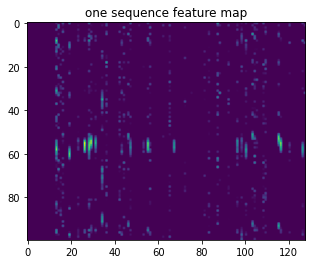

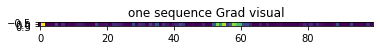

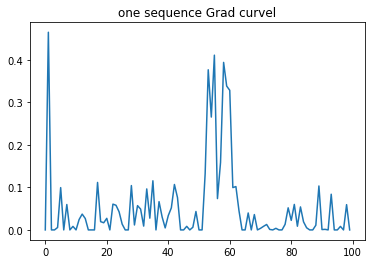

In [249]:
#(1)首先确定 y_c 和 A_k 的值
# print("y_test:",y_test[0])
# print("预测结果",model(X_test[:1]).numpy())#说明输出的第二个为正样本所代表的神经元

last2_output = model.layers[-2].output#倒数第二个Dense层的输出
weights = model.trainable_variables[-2][:,1]#(128)
bias = model.trainable_variables[-1][1]#(1)
y_c =  tf.reduce_sum(last2_output * weights)+bias
feature_map = model.layers[-5].output

model_before_softmax = Model(inputs = model.input,outputs = [y_c,feature_map] )

y_c,feature_map = model_before_softmax(X_test[0:1])#正样本softmax之前的值
print("(1)y_c:",y_c)
print("(2)feature map:")

plt.imshow(feature_map.numpy().reshape(100,128))
plt.title("one sequence feature map")
plt.show()

#(2)计算alpha值
with tf.GradientTape() as tape:
    y_c,A_k = model_before_softmax(X_test[0:1])
alpha = tape.gradient(y_c,A_k)



alpha = alpha.numpy().reshape(100,128)
A_k = A_k.numpy().reshape(100,128)

#(3)计算并绘制grad-CAM图
def relu(x):
    return np.maximum(x,0)

L_grad_CAM = relu(np.sum(alpha*A_k,axis=1))

plt.imshow(L_grad_CAM.reshape(1,100))
plt.title("one sequence Grad visual")
plt.show()

plt.plot(L_grad_CAM)
plt.title("one sequence Grad curvel")
plt.show()

In [251]:
#(2)计算alpha值
L_grad_CAMs=[]
X_True = X_test[y_test==1]
for i in range(len(X_True)):
    with tf.GradientTape() as tape:
        y_c,A_k = model_before_softmax(X_True[i:i+1])
    alpha = tape.gradient(y_c,A_k)



    alpha = alpha.numpy().reshape(100,128)
    A_k = A_k.numpy().reshape(100,128)

    #(3)计算并绘制grad-CAM图
    def relu(x):
        return np.maximum(x,0)

    L_grad_CAM = relu(np.sum(alpha*A_k,axis=1))
    L_grad_CAMs.append(L_grad_CAM)


Text(0, 0.5, 'different seqs')

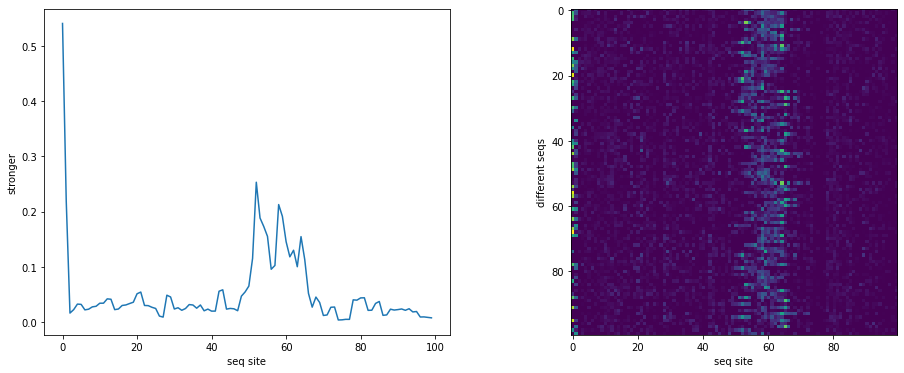

In [283]:
fit,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(np.average(np.vstack(L_grad_CAMs),axis=0))
ax[0].set_xlabel("seq site")
ax[0].set_ylabel("stronger")

ax[1].imshow(np.vstack(L_grad_CAMs[:100]))
ax[1].set_xlabel("seq site")
ax[1].set_ylabel("different seqs")